## Setup

In [2]:
import scipy.optimize as opt
import numpy as np
import scipy.linalg as lin
%matplotlib inline
import matplotlib.pyplot as plt
import collections
import time

import blockRandom as genMat

from IPython.display import clear_output
#Fill entire screen with cells
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [19]:
#for generating eigenvalue histograms
def load_eigs(directory,fileName,n_files):
    eigs = np.array([])
    for i in range(5): #files are indexed from 1
        eigs = np.concatenate((eigs,np.load(directory + fileName + str(i+1) + '.npy')))
    return eigs
def gen_rho_hist(eigs,xrange,yrange):
    [hist,xbins,ybins] = np.histogram2d(np.real(eigs),np.imag(eigs),bins = [xrange,yrange])
    dx = np.abs(xbins[1]-xbins[0])
    dy = np.abs(ybins[1]-ybins[0])
    rhoNum =  1.0*hist/eigs.size/(dx*dy)
    #print(np.sum(rhoNum*dx*dy))
    return rhoNum


In [52]:
#one iteration of the self-consistent equation
def fixedPointCov(a,c,d,zbar,ep,gsq,T,fracs):
    aNum = ep+np.dot(a*fracs,gsq)
    dNum = ep+np.dot(gsq,d*fracs)
    cNum = -np.dot(T,np.conj(c)*fracs)+zbar
    bNum = np.conj(cNum)
    q = (aNum)*(dNum) + (bNum)*(cNum)
    return np.array([aNum,cNum,dNum])/q
#iterate self consistent equations to compute green's function at a point z
def trGreenIterate(gsq,T,fracs,z,max_iterations,ep=0,safe=True,returnC = True,printWarning=False,returnIterations=False,threshold = 1E-6):
    m = fracs.shape[0]
    init = np.ones([m])/np.sqrt(m)
    zbar = np.conj(z)
    a = init.copy(); c = init.copy(); d = init.copy()
    for it in range(max_iterations):
        lastc = c.copy()
        [a,c,d] = fixedPointCov(a,c,d,zbar,ep,gsq,T,fracs)
        #stop iterating when threshold is reached
        if np.vdot(c-lastc,c-lastc) < threshold:
            break
    if it == max_iterations - 1 and printWarning:
        print('Reached ', it, ' iterations at ', z)
    if returnIterations: #return # of iterations
        return it
    if returnC: #return trace of c
        trace = np.dot(c,fracs)
    else: #return trace/i of A + D
        trace = np.imag(np.dot(a,fracs) + np.dot(d,fracs))
    return trace
#compute the eigenvalue density given a grid of points in the complex plane
def calc_density_grid(gsq,T,fracs,zGrid,max_iterations,threshold=1E-6):
    greenGrid = np.vectorize(lambda z : trGreenIterate(gsq,T,fracs,z,max_iterations,returnC=True,threshold=threshold))(zGrid)
    dcy = np.diff(greenGrid)
    dcx = np.diff(greenGrid.T).T
    #average elements to make array square
    dcy = np.array(list(map(lambda row: np.convolve(row,np.ones([2])/2,'same')[1:],dcy.T))).T
    dcx = np.array(list(map(lambda row: np.convolve(row,np.ones([2])/2,'same')[1:],dcx)))
    dx = np.abs(np.real(zGrid[0,0]-zGrid[1,0]))
    dy = np.abs(np.imag(zGrid[0,0]-zGrid[0,1]))
    dzbar = 0.5*(dcx/dx+1j*dcy/dy)
    return np.real(dzbar)/(np.pi)

## Block structured matrix

parameters for the block structured random matrix example

In [112]:
m = 3

fracs = np.array([1,2,3])
fracs = 1.0*fracs/np.sum(fracs)

gsq= np.array([[ 0.54434103,  0.83188996,  0.64541734],
    [ 0.9481512 ,  0.45818944,  0.00875261],
    [ 0.7187979 ,  0.58533195,  0.54528167]])

gmat = np.sqrt(gsq)

tau = np.array([[.5,-.2,.9],
                 [-.2,.3,.1],
                 [.9,.1,-.6]])

T = np.sqrt(gsq)*np.sqrt(gsq.T)*tau

Generate eigenvalues by exact diagonalization (these have been precomputed and stored as *.npy files)

In [119]:
n = 1000
n_mats = 200
popSizes = np.round(fracs*n)
eigs = np.array([])
for i in range(n_mats):
    if i%(n_mats/10)==0:
        print(i)
    if i==0:
        t0 = time.time()
    J = genMat.generateMatrix(popSizes,gmat,tau,complex=True)
    eigs = np.append(eigs,np.linalg.eigvals(J))
    if i==0:
        print(time.time()-t0)
#np.save('data/covBlock_1.npy',eigs)

0
4.426026821136475


Routines for computing green's function and eigenvalue density

Generate block figures (subfigures of Figure 1)

0.999846
1.0
0.999644


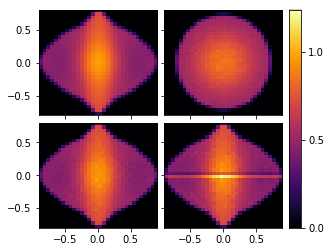

In [126]:
max_iterations = 10000
xmin, xmax = -0.9,0.9
ymin, ymax = -0.8,0.8
n_bins = 32
xrange = np.linspace(xmin,xmax,n_bins+1)
yrange = np.linspace(ymin,ymax,n_bins+1)
zGrid = xrange.reshape(-1,1) + 1j*yrange.reshape(1,-1)

xCenters = np.convolve(xrange,np.ones([2])/2,'same')[1:]
yCenters = np.convolve(yrange,np.ones([2])/2,'same')[1:]

directory = 'data/'
cov_hist = gen_rho_hist(load_eigs(directory,'covBlock',5),xrange,yrange)
nocov_hist = gen_rho_hist(load_eigs(directory,'noCovBlock',5),xrange,yrange)
covre_hist = gen_rho_hist(load_eigs(directory,'covBlockRe_',10),xrange,yrange)

cov_rho_grid = calc_density_grid(gsq,T,fracs,zGrid,max_iterations)
nocov_rho_grid = calc_density_grid(gsq,T*0,fracs,zGrid,max_iterations)

hist_list = [cov_rho_grid,nocov_hist,cov_hist,covre_hist]
vmax = max(list(map(np.max,hist_list)))
vmin = max(list(map(np.min,hist_list)))

from mpl_toolkits.axes_grid1 import AxesGrid
fig = plt.figure(figsize=(6, 4))
axes_grid = AxesGrid(fig, 111,
                nrows_ncols=(2, 2),
                axes_pad=0.1,
                cbar_mode='single',
                cbar_location='right',
                cbar_pad=0.1
                )
for i,hist,ax in zip(range(4),hist_list,axes_grid):
    im = ax.imshow(np.real(hist).T,
                   interpolation='none',
                   extent=[xrange[0],xrange[-1],yrange[0],yrange[-1]],
                   vmax=vmax,vmin=vmin,
                   cmap = 'inferno')
cbar = ax.cax.colorbar(im)
cbar.ax.set_yticks([0,0.5,1])
plt.show()


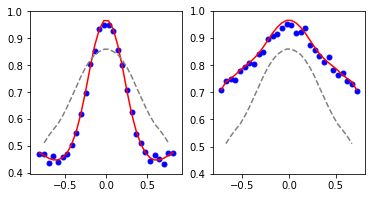

In [127]:
dot_size = 24
plt.figure(figsize=(6,3))

ax1 = plt.subplot(1,2,1)
plt.plot(xCenters[1:-1],cov_rho_grid.T[n_bins//2,1:-1],c='red')
plt.scatter(xCenters[1:-1],cov_hist.T[n_bins//2,1:-1],c='blue',s=dot_size)
plt.plot(xCenters[2:-2],nocov_rho_grid[n_bins//2,2:-2],c='gray',linestyle='--')

ax2 = plt.subplot(1,2,2,sharey=ax1)
plt.scatter(yCenters[1:-1],cov_hist[n_bins//2,1:-1],c='blue',s=dot_size)
plt.plot(yCenters[1:-1],cov_rho_grid[n_bins//2,1:-1],c='red')
plt.plot(yCenters[2:-2],nocov_rho_grid[n_bins//2,2:-2],c='gray',linestyle='--')
plt.ylim(0.4,1)
plt.show()

## Continuous gain dependence

functions for generating orientation map and $g_{ij}$

In [48]:
def calc_theta(x,y):
    #generate angles between 0, 180 deg
    return 180./np.pi*np.angle(np.cos(4*np.pi*x)+ 1j*np.cos(4*np.pi*y))/2+90
@np.vectorize
def calc_gFun(x1,y1,x2,y2,th1,th2):
    wr = 0.2; wth = 20
    
    diff = abs(th1-th2)
    dtheta = 180-diff if diff>90 else diff
    out = np.exp(-((x1-x2)**2+(y1-y2)**2)/wr**2-(1.*dtheta/wth)**2)
    return out + 0.01

Plot orienation map

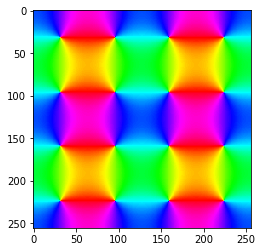

In [147]:
nx = 256
ny = nx
xlist = np.linspace(0, 1, nx)
ylist = np.linspace(0, 1, ny)
xgrid, ygrid = np.meshgrid(xlist, ylist)

orients = calc_theta(xgrid,ygrid)
plt.imshow(orients,cmap='hsv')
plt.show()

generate $g_{mn}$ and $\tau_{mn}$, plot $g_{mn}$

nx:  16
blockSize:  8
0.16863369941711426


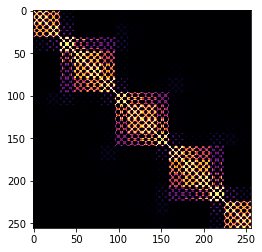

In [49]:
nBlocks = 16*16

nx = int(np.sqrt(nBlocks)); ny = nx
print("nx: ", nx)
print("blockSize: ", blockSize)

xlist = np.linspace(0, 1, nx)
ylist = np.linspace(0, 1, ny)
xgrid, ygrid = np.meshgrid(xlist, ylist)

orients = calc_theta(xgrid,ygrid)
plt.imshow(orients,cmap='hsv')

t1 = time.time()
xlist = np.tile(xlist,ny)
ylist = np.repeat(ylist,nx)
xgridi, xgridj = np.meshgrid(xlist,xlist)
ygridi, ygridj = np.meshgrid(ylist,ylist)
orientsflat = orients.reshape(-1)
thetai, thetaj = np.meshgrid(orientsflat,orientsflat)
gmat = calc_gFun(xgridi,ygridi,xgridi,ygridj,thetai,thetaj)
taumat = 0.8*gmat
gsq = gmat**2
T = gmat*gmat.T*taumat
fracs = np.ones(nBlocks)/nBlocks

print(time.time() - t1)

plt.imshow(gmat,interpolation='none',cmap='inferno'); plt.show()

generate eigenvalues by exact diagonalization (these have been precomputed and stored as *.npy files)

In [65]:
def generate_matrix(g_ij,tau_ij,complex = False):
    n = g_ij.shape[0]
    if complex:
        J = np.random.normal(0,1,[n,n])/np.sqrt(2*n) + 1.j*np.random.normal(0,1,[n,n])/np.sqrt(2*n)
    else:
        J = np.random.normal(0,1,[n,n])/np.sqrt(n)
    for i in range(n):
        for j in range(i):
            g1 = g_ij[i,j]; g2 = g_ij[j,i]
            rho = tau_ij[i,j]
            if complex:
                pair = [J[i,j],J[j,i]]
                J[i,j] = g1*pair[0]
                J[j,i] = g2*(rho*np.conj(pair[0])+np.sqrt(1.-rho*rho)*pair[1])
            else:
                pair = np.array([J[i,j],J[j,i]])
                J[i,j] = g1*pair[0]
                J[j,i] =  g2*(rho*pair[0]+np.sqrt(1.-rho*rho)*pair[1])
    return J

blockSize = 8
n = blockSize*nBlocks
g_ij = np.kron(gmat,np.ones((blockSize,blockSize)))
tau_ij = np.kron(taumat,np.ones((blockSize,blockSize)))

n_mats = 2
eigs = np.array([])
for i in range(n_mats):
    if i%(n_mats/10)==0:
        print(i)
    t1 = time.time()
    J = generate_matrix(g_ij,tau_ij,complex=True)
    eigs = np.append(eigs,np.linalg.eigvals(J))
    print( time.time()-t1)
#np.save('v1_2k_16x16_1.npy',eigs)

0
61.10621523857117
65.31776404380798


Generate histograms of figure 2

74.40112543106079
54.516146183013916


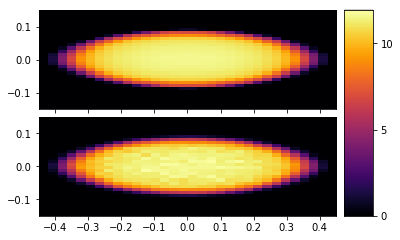

In [63]:
max_iterations = 2000
xmin, xmax = -0.45,0.45
ymin, ymax = -0.15,0.15
n_bins = 32
xrange = np.linspace(xmin,xmax,n_bins+1)
yrange = np.linspace(ymin,ymax,n_bins+1)
zGrid = xrange.reshape(-1,1) + 1j*yrange.reshape(1,-1)

xCenters = np.convolve(xrange,np.ones([2])/2,'same')[1:]
yCenters = np.convolve(yrange,np.ones([2])/2,'same')[1:]

directory = 'data/'
cov_hist = gen_rho_hist(load_eigs(directory,'v1_2k_16x16_',20),xrange,yrange)

#DEBUG##
aInit = np.ones(nBlocks)/nBlocks
cInit = aInit; dInit = aInit
##
t0 = time.time()
cov_rho_grid = calc_density_grid(gsq,T,fracs,zGrid,max_iterations)
print(time.time()-t0)

t0 = time.time()
nocov_rho_grid = calc_density_grid(gsq,T*0,fracs,zGrid,max_iterations)
print(time.time()-t0)

hist_list = [cov_rho_grid,cov_hist]
vmax = max(list(map(np.max,hist_list)))
vmin = max(list(map(np.min,hist_list)))

from mpl_toolkits.axes_grid1 import AxesGrid
fig = plt.figure(figsize=(6, 4))
axes_grid = AxesGrid(fig, 111,
                nrows_ncols=(2, 1),
                axes_pad=0.1,
                cbar_mode='single',
                cbar_location='right',
                cbar_pad=0.1
                )
for i,hist,ax in zip(range(2),hist_list,axes_grid):
    im = ax.imshow(np.real(hist).T,
                   interpolation='none',
                   extent=[xrange[0],xrange[-1],yrange[0],yrange[-1]],
                   vmax=vmax,vmin=vmin,
                   cmap = 'inferno')
cbar = ax.cax.colorbar(im)
cbar.ax.set_yticks([0,5,10])
plt.show()


plots of cross sections for figure 2

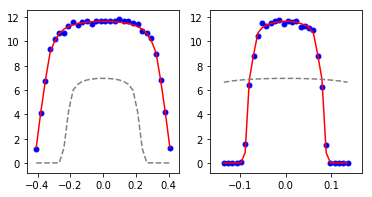

In [66]:
dot_size = 24
plt.figure(figsize=(6,3))

ax1 = plt.subplot(1,2,1)
plt.plot(xCenters[1:-1],cov_rho_grid.T[n_bins//2,1:-1],c='red')
plt.scatter(xCenters[1:-1],cov_hist.T[n_bins//2,1:-1],c='blue',s=dot_size)
plt.plot(xCenters[1:-1],nocov_rho_grid.T[n_bins//2,1:-1],c='gray',linestyle='--')

ax2 = plt.subplot(1,2,2,sharey=ax1)
plt.scatter(yCenters[1:-1],cov_hist[n_bins//2,1:-1],c='blue',s=dot_size)
plt.plot(yCenters[1:-1],cov_rho_grid[n_bins//2,1:-1],c='red')
plt.plot(yCenters[1:-1],nocov_rho_grid[n_bins//2,1:-1],c='gray',linestyle='--')
plt.show()